Using ZigZag
===
[ZigZag](https://pypi.python.org/pypi/ZigZag) is a (very) small library [I](http://twitter.com/generativist) wrote for calculating the peaks and valleys of a sequence (e.g. time series data). It also can calculate the [maximum drawdown](http://en.wikipedia.org/wiki/Drawdown_(economics)), a useful metric for trading analysis. The repository is on github at [https://github.com/jbn/ZigZag](https://github.com/jbn/ZigZag). Prior to version `0.1.4` it optionally used [`numba`](https://github.com/numba/numba); starting with version `0.1.4`, I switched to [`Cython`](http://cython.org/). 

This notebook demonstrates how to use ZigZag, and draws attention to a few caveats.

Installation
---
`pip install zigzag`

Basic Usage
---

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from zigzag import *

In [4]:
# This is not nessessary to use zigzag. It's only here so that
# this example is reproducible.
np.random.seed(1997)

In [5]:
X = np.cumprod(1 + np.random.randn(100) * 0.01)
pivots = peak_valley_pivots(X, 0.03, -0.03)

In [6]:
def plot_pivots(X, pivots):
    plt.xlim(0, len(X))
    plt.ylim(X.min()*0.99, X.max()*1.01)
    plt.plot(np.arange(len(X)), X, 'k:', alpha=0.5)
    plt.plot(np.arange(len(X))[pivots != 0], X[pivots != 0], 'k-')
    plt.scatter(np.arange(len(X))[pivots == 1], X[pivots == 1], color='g')
    plt.scatter(np.arange(len(X))[pivots == -1], X[pivots == -1], color='r')

The following plot illustrates how the sequence was annotated. 

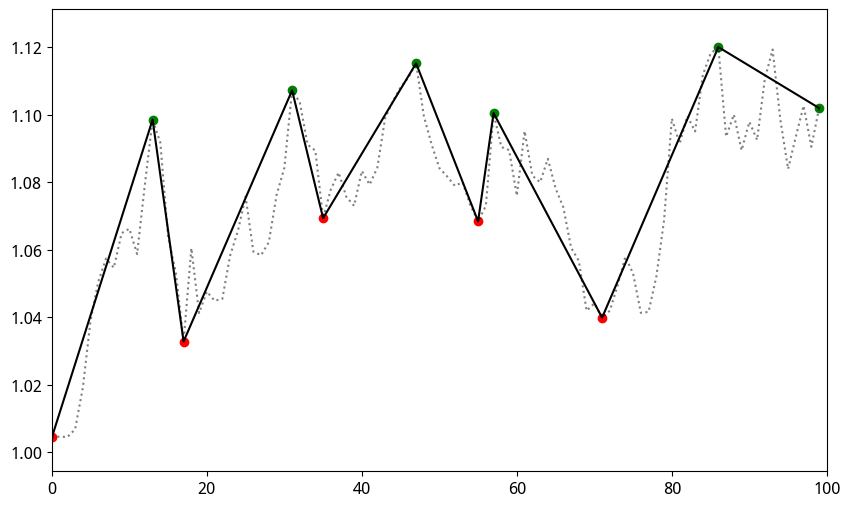

In [7]:
plot_pivots(X, pivots)

The following shows how you can use `pivots_to_modes` to inspect the segments.

In [8]:
modes = pivots_to_modes(pivots)
pd.Series(X).pct_change().groupby(modes).describe()

,count,mean,std,min,25%,50%,75%,max
-1,43.0,-0.004875,0.009995,-0.025602,-0.011249,-0.005225,0.000075,0.017768
1,56.0,0.005506,0.009663,-0.018131,0.000144,0.004643,0.010315,0.028133


Calculate the peak to valley returns for all of the segments.

In [9]:
compute_segment_returns(X, pivots)

array([ 0.09370263, -0.05981991,  0.07204542, -0.03419711,  0.04289563,
       -0.04197655,  0.03001853, -0.05506552,  0.07707074, -0.016124  ])

Finally, compute the oft-quoted (in financial literature) `max_drawdown`.

In [10]:
max_drawdown(X)

0.06755575755355037

Pandas Compatability
---
The `peak_valley_pivots` function works on pandas `series` assuming the index is either a DateTimeIndex or is \[0, n). [Pandas](http://pandas.pydata.org/) is great.

In [11]:
from pandas_datareader import get_data_yahoo

X = get_data_yahoo('GOOG')['Adj Close']
pivots = peak_valley_pivots(X.values, 0.2, -0.2)
ts_pivots = pd.Series(X, index=X.index)
ts_pivots = ts_pivots[pivots != 0]
X.plot()
ts_pivots.plot(style='g-o');

ModuleNotFoundError: No module named 'pandas_datareader'

# `#WONTFIX`

[in PR#13 `ytian` writes](https://github.com/jbn/ZigZag/pull/13),

> the code has some bugs for some test cases:
> code:
>
> a = np.array([1, 1.2, 1.5, 1.8, 2.4, 3.3, 2.4, 1.5, 1.6])  
> peak_valley_pivots(a, 0.2, -0.2) 
> 
> output (wrong result)  
> array([-1, 0, 0, 0, 0, 1, 0, 0, 1]) 
> 
> output (after fix)  
> array([-1, 0, 0, 0, 0, 1, 0, -1, 1])


Visually,

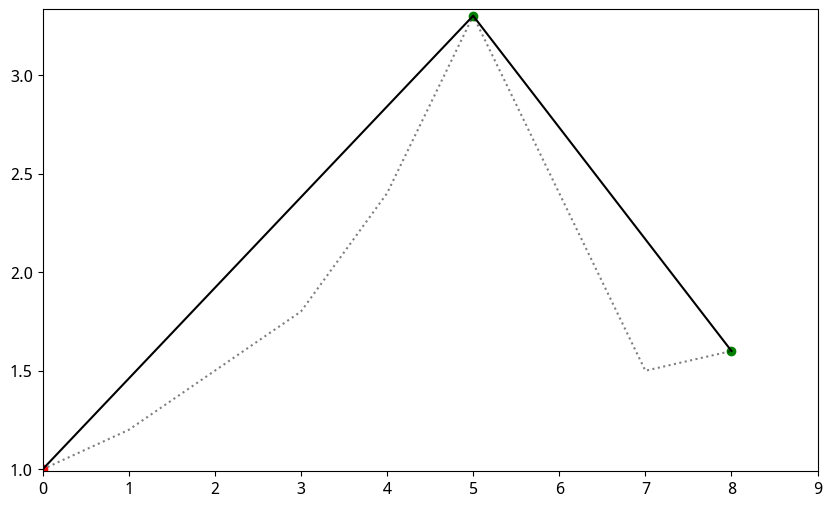

In [12]:
X = np.array([1, 1.2, 1.5, 1.8, 2.4, 3.3, 2.4, 1.5, 1.6])
pivots = peak_valley_pivots(X, 0.2, -0.2)
plot_pivots(X, pivots)

Intuitively, what he is saying seems to make sense. 

- 3.3 is the peak
- 1.5 is the lowest point after it
- 1.6 is above 1.5 so can't be the valley pivot

The difficulty here is that 1.6 is not a peak, either. A local one, yes, but not according to the segmenter which requires `>20%` which 1.6 above 1.5 does not satisfy.